<a href="https://colab.research.google.com/github/zhiyuan-95/db-vae/blob/main/standard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install comet_ml --quiet
import comet_ml
# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = "ROr5Iwf4PjYLL2ZhtmHtYHhoP"

# Import Tensorflow 2.0
import tensorflow as tf
import random
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc
# Download and import the MIT 6.S191 package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.9/771.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 46.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.9/149.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.1/920.1 kB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 146.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.9 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263889489/1263889489 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [ ]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

In [ ]:
### Create a Comet experiment to track our training run ###
def create_experiment(project_name, i):
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name=project_name)
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value[i])
  experiment.flush()
  return experiment

In [ ]:
def compute_predicted_mean(model_forward_fn, val_groups, eps=1e-6):
    group_means = []
    for g in val_groups:
        logits = model_forward_fn(np.asarray(g, np.float32), training=False)
        probs = tf.sigmoid(logits).numpy().reshape(-1)
        group_means.append(float(np.mean(probs)))
    return group_means

def compute_validation(group_means):
    predicted_mean = float(np.mean(group_means))
    return predicted_mean

def compute_db_validation(group_means):
  gm = np.asarray(group_means, dtype=np.float64)
  return float(np.max(gm) - np.min(gm))

def validation(model_forward_fn, val_groups, eps=1e-6):
  gm = compute_predicted_mean(model_forward_fn, val_groups)
  val_score = compute_validation(gm)
  db_val_score = compute_db_validation(gm)
  del gm
  return val_score, db_val_score

In [ ]:
class EMASmoother:
    def __init__(self, beta=0.90):
        self.beta = beta
        self.state = None
    def update(self, x):
        x = float(x)
        self.state = x if self.state is None else self.beta*self.state + (1-self.beta)*x
        return self.state

class EarlyStopper:
    def __init__(self, patience=2):
        """
        patience: #epochs with no improvement allowed
        min_delta: absolute (or relative if use_relative=True) improvement threshold
        """
        self.patience = patience
        self.best_val = float("-inf")   # higher is better
        self.best_epoch = -1
        self.bad_epochs = 0
        self.should_stop = False
        self.reason = None

    def update(self, val_score, epoch):
        if val_score>self.best_val:
            self.best_val = val_score
            self.best_epoch = epoch
            self.bad_epochs = 0
        else:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                self.should_stop = True
                self.reason = "no_improvement"

        return self.should_stop, self.reason,self.best_val,self.best_epoch


In [ ]:
def checkAndLog(loss, val_score, dbval_score, epoch):
  should_stop, reason,best_val, best_epoch = early.update(val_score, epoch=epoch)
  experiment.log_metric("loss_ema",           loss,                 step=epoch)
  experiment.log_metric("val",            val_score,            step=epoch)
  experiment.log_metric("dbval",          dbval_score,          step=epoch)
  experiment.log_metric('best_val',       best_val,              step=epoch)
  experiment.log_metric('best_epoch',     best_epoch,              step=epoch)
  return should_stop, reason, best_epoch

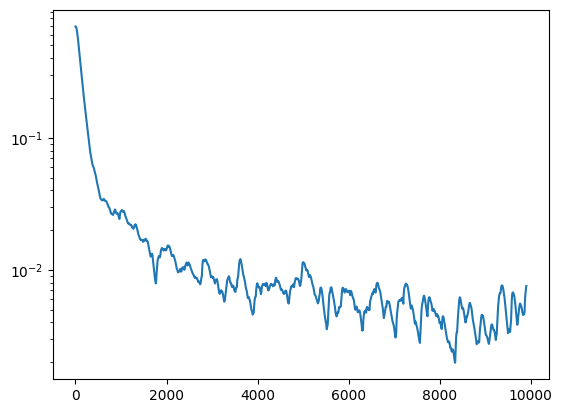

Expmt 10/10 | trial 3/ 3 | Epoch 6/15 | BS=65 | LR=0.000920: 100%|██████████| 1690/1690 [00:24<00:00, 70.25it/s]


[EarlyStop] epoch=5 reason=no_improvement best_epoch=3


COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : capable_spire_1256
COMET INFO:     url                   : https://www.comet.com/zhiyuan-jin/lab2-part2-standard-new-metrix/154c5b9b984d49a0b63ca8e803304446
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     best_epoch [6]    : (0, 3)
COMET INFO:     best_val [6]      : (0.5937082767486572, 0.7186698317527771)
COMET INFO:     dbval [6]         : (0.01650106906890869, 0.2022516131401062)
COMET INFO:     loss [510]        : (7.773348897899268e-07, 0.6956232190132141)
COMET INFO:     loss_ema [6]      : (0.002671843904705223, 0.0

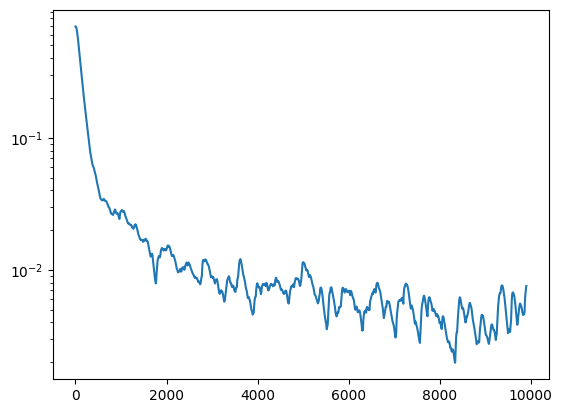

In [ ]:
### Train the standard CNN ###
num_expt = 10
trial_per_expt = 3
#validation set
test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
epoch_max = 15
# Training hyperparameters
params = dict(
  batch_size = [random.choice([x for x in range(20,70,5)]) for _ in range(num_expt)],
  learning_rate = [np.round(random.uniform(5e-5,1e-3),6)for _ in range(num_expt)],
)

for itr in range(num_expt):
  for _ in range(trial_per_expt):

    experiment = create_experiment("Lab2-Part2-standard_new_metrix", itr)
    optimizer = tf.keras.optimizers.Adam(params["learning_rate"][itr]) # define our optimizer
    loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
    plotter = mdl.util.PeriodicPlotter(sec=10, scale='semilogy')
    if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
    standard_classifier = make_standard_classifier()
    @tf.function
    def standard_train_step(x, y):
      with tf.GradientTape() as tape:
        # feed the images into the model
        logits = standard_classifier(x)
        # Compute the loss
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
      # Backpropagation
      grads = tape.gradient(loss, standard_classifier.trainable_variables)
      optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
      return loss
    early = EarlyStopper()

    # The training loop!
    step = 0
    for epoch in range(epoch_max):
      loss_smoother = EMASmoother(beta=0.95)
      for idx in tqdm(range(loader.get_train_size()//params["batch_size"][itr]),
                      desc=f"Expmt {itr+1}/{num_expt} | "
                        f"trial {_+1}/ {trial_per_expt} | "
                      f"Epoch {epoch+1}/{epoch_max} | "
                    f"BS={params['batch_size'][itr]} | LR={params['learning_rate'][itr]:.6f}"):
        # Grab a batch of training data and propagate through the network
        x, y = loader.get_batch(params["batch_size"][itr])
        loss = standard_train_step(x, y)
        loss_smooth = loss_smoother.update(loss.numpy().mean())
        loss_history.append(loss_smooth)
        plotter.plot(loss_history.get())
        if idx%20==0:
          experiment.log_metric("loss", loss.numpy().mean(), step=step)
          experiment.log_metric('loss_smooth', loss_smooth, step=step)
        step += 1
        del x,y, loss, loss_smooth

# regular validation and debiasing validation
      loss_ema = float(loss_history.get()[-1])
      val_score, dbval_score = validation(standard_classifier, test_faces)
# early stopping and log the experiments
      should_stop, reason, best_epoch = checkAndLog(loss_ema, val_score, dbval_score, epoch)
      if should_stop:
          print(f"[EarlyStop] epoch={epoch} reason={reason} best_epoch={best_epoch}")
          break
      del should_stop, reason, best_epoch, loss_ema, val_score, dbval_score
    del (loss_ema, val_score, dbval_score, loss_history)
    tf.keras.backend.clear_session()
    gc.collect()
    experiment.end()

log

*   the patience is 3, the stopping epoch should always equals to best_epoch + 3 if the stopping epoch less than 15 (**fixed**)
*   indexing error regarding recorded epoch  (**fixed**)

